# Latent Dynamical Systems and Expectation-Maximization

__Overview__: This lab is meant as an introduction to expectation-maximization and Kalman filtering.

__Goals__: Students should:

1. Be able to implement the expectation-maximization algorithm for latent space dynamical models.
2. Be able to calculate the log posterior of an LDS model.
3. Gain intuition for how iterations of the EM algorithm improve the quality of the estimate.

In [2]:
from typing import Any, Tuple

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import pandas as pd

In [3]:
def plot_means_and_cov(means: np.ndarray, covariances: np.ndarray, ax: Any, color: str, label: str):
    """Plot the mean and covariance of our filtering/smoothing.

    Args:
        means: Means to plot.
        covariances: Covariances to plot.
        ax: Axis on which to plot.
        color: Color for plotting.
        label: Label for plotted points.

    Notes:
        Will plot the 68% contours from the covariances.
    """
    # Plot the trend line.
    ax.plot(means[:,0], means[:,1], '-', color=color, label=label)

    # Plot the ellipses for covariances. Assume they are diagonal (true for this lab).
    for i in range(len(means)):
        elip = Ellipse((means[i,0], means[i,1]), np.sqrt(covariances[i,0,0]), np.sqrt(covariances[i,1,1]), color=color, alpha=0.7)
        ax.add_patch(elip)

def sample_lds(n_timesteps: int, transition_matrix: np.ndarray, transition_covariance: np.ndarray, 
               observation_matrix: np.ndarray, observation_covariance: np.ndarray, mu_zero: np.ndarray, 
               cov_zero: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Sample from a latent dynamical system with the given parameters.

    Args:
        n_timesteps: Number of timesteps of data to sample.
        transition_matrix: Transition matrix between latent states. This is A
        transition_covariance: Covariance of latent state noise. This is Q
        observation_matrix: Observation matrix from latent state to observation. This is C.
        observation_covariance: Covariance of observation noise. This is R.
        mu_zero: Mean of initial latent state.
        cov_zero: Covariance of initial latent state.

    Returns:
        Latent and observed states from sampling.
    """
    # In our model we assume there is no initial observation.
    latent_state = np.zeros([n_timesteps+1, 2])
    observed_state = np.zeros([n_timesteps, 2])

    latent_state[0] = np.random.multivariate_normal(mu_zero, cov_zero)

    # Iterate through latent states.
    for t in range(n_timesteps):
        latent_state[t+1] = (
            np.dot(transition_matrix, latent_state[t]) + 
            np.random.multivariate_normal(np.zeros(2), transition_covariance)
        )
        observed_state[t] = (
            np.dot(observation_matrix, latent_state[t+1]) + 
            np.random.multivariate_normal(np.zeros(2), observation_covariance)
        )
    return latent_state, observed_state
    

## Part I: Expectation-Maximization for Latent Dynamical System

To start this lab, we'll return to our same Kalman filtering / smoothing modeling from last week and fold in our new expectation-maximization algorithm. I have supplied you with a function for sampling a latent space and a set of observations that we will use to generate our data. You will have to import your solutions from last week into the class (with a small modification to the smoothing function). 

The expectation-maxiization equations were provided in this week's lecture, and there are test functions for each of the equations to make sure that your implementation is correct.

* Import your solution for _init_, _filter_ and _smooth_ from last week's lab.
* Fill out the _expectation_maximization_ function in the KalmanFilter class.

In [ ]:
class KalmanFilter:
    """Class that implements the Kalman Filter for our LDS model.

    Args:
        sigma_w: Standard deviation of latent space noise.
        sigma_v: Standard deviation of observation noise.
        a: Magnitude of latent space transition matrix.
        c: Magnitude of the observation matrix.
        dim_z: Dimension of latent space.
        dim_x: Dimension of observation space.
        sigma_w_zero: Initial standard deviation of the zero state.
        mu_zero: Initial mean of the zero state.
    """
    def __init__(self, sigma_w: float, sigma_v: float, a: float, c: float, dim_z: int, 
                 dim_x: int, sigma_w_zero: float, mu_zero: np.ndarray):
        """Initialize our class."""
        # Save a few variables for bookkeeping
        self.dim_x = dim_x
        self.dim_z = dim_z

        # Used in the EM function.
        self.smooth_matrices = None # The F_t matrices from the notes. Will need to be saved.
        
        # TODO: Implement the transition, observation, and noise covariance matrices.
        self.transition_covariance = np.eye(dim_z) * sigma_w**2
        self.observation_covariance = np.eye(dim_x) * sigma_v**2
        self.transition_matrix = np.eye(dim_z) * a
        self.observation_matrix = np.eye(dim_x, dim_z) * c

        # TODO: Implement the initial covariance and mean of the zero state.
        self.mu_zero = mu_zero
        self.cov_zero = np.eye(dim_z) * sigma_w_zero**2

    def filter(self, data: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Calculate the filtered mean and covariances of the latent space.

        Args:
            data: Observations with shape [n_observations, dim_x]

        Returns:
            Filtered mean and covariance for the latent space. The first dimension
            of both should by n_observations+1 since the initial latent state has no
            paired observation.
        """
        
        # Make sure the dimensions match and create some placeholders for the outputs.
        n_observations, dim_x = data.shape
        assert dim_x == self.dim_x
        filtered_means = np.zeros((n_observations + 1, self.dim_z))
        filtered_covs = np.zeros((n_observations + 1, self.dim_z, self.dim_z))
        
        # TODO: Implement filtering.
        filtered_means[0] = self.mu_zero
        filtered_covs[0] = self.cov_zero

        for t in range(n_observations):
            # Predict
            pred_mean = self.transition_matrix @ filtered_means[t]
            pred_cov = self.transition_matrix @ filtered_covs[t] @ self.transition_matrix.T + self.transition_covariance

            # Update
            S = self.observation_matrix @ pred_cov @ self.observation_matrix.T + self.observation_covariance
            K = pred_cov @ self.observation_matrix.T @ np.linalg.inv(S)
            y = data[t] - self.observation_matrix @ pred_mean
            filtered_means[t+1] = pred_mean + K @ y
            filtered_covs[t+1] = (np.eye(self.dim_z) - K @ self.observation_matrix) @ pred_cov
            
        return filtered_means, filtered_covs

    def smooth(self, data: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Calculate the smoothed mean and covariances of the latent space.

        Args:
            data: Observations with shape [n_observations, dim_x]

        Returns:
            Smoothed mean and covariance for the latent space. The first dimension
            of both should by n_observations+1 since the initial latent state has no
            paired observation.

        Notes:
            
        """
        # Validate the data dimensions.
        n_observations, dim_x = data.shape
        assert dim_x == self.dim_x
        
        # Run the forward path
        filtered_means, filtered_covs = self.filter(data)
        
        # Create holders for outputs
        smoothed_means = np.zeros((n_observations + 1, self.dim_z))
        smoothed_covs = np.zeros((n_observations + 1, self.dim_z, self.dim_z))
        cross_covs = np.zeros_like(filtered_covs)
        self.smooth_matrices = np.zeros((n_observations + 1, self.dim_z, self.dim_z))
        
        # TODO: Implement smoothing.
        smoothed_means[-1] = filtered_means[-1]
        smoothed_covs[-1] = filtered_covs[-1]

        for t in reversed(range(n_observations)):
            pred_mean = self.transition_matrix @ filtered_means[t]
            pred_cov = self.transition_matrix @ filtered_covs[t] @ self.transition_matrix.T + self.transition_covariance

            # Compute smoother gain
            C = filtered_covs[t] @ self.transition_matrix.T @ np.linalg.inv(pred_cov)

            # Update smoothed estimates
            smoothed_means[t] = filtered_means[t] + C @ (smoothed_means[t+1] - pred_mean)
            smoothed_covs[t] = filtered_covs[t] + C @ (smoothed_covs[t+1] - pred_cov) @ C.T
            self.smooth_matrices[t+1] = C

            if t > 0:
                cross_covs[t] = (
                    smoothed_covs[t]
                    @ C.T
                )

        # Did you remember to save the F_t calculations for EM?
        assert np.sum(np.abs(self.smooth_matrices)) > 0
        # Did you remember to set the last F_t calculation? We don't need it for EM,
        # but we do need it for completeness.
        assert np.sum(np.abs(self.smooth_matrices[-1])) > 0

        return smoothed_means, smoothed_covs, cross_covs  

    def expectation_maximization(self, data: np.ndarray, n_iter: int):
        """Run the expectation-maximizaation algorithm on our LDS parameters.

        Args:
            data: Observations with shape [n_observations, dim_x].
            n_iter: The number of iterations of the expectation-maximization algorithm to run.

        Notes:
            Updates the internal representations of the LDS parameters but has no outputs.
        """
        # Validate the data dimensions.
        n_observations, dim_x = data.shape
        assert dim_x == self.dim_x
        
        # TODO: Implement EM Iterations.
        for iter_num in range(n_iter):
    
            ### Expectation Step ###
            # Get the smoothed state for the current model parameters.
            smoothed_state_means, smoothed_state_covariances, cross_covs = self.smooth(data)
            
            # Solve for E[z_t], E[z_t z_{t-1}^T], E[z_t z_t^T] for use in EM.
            expect_zt = smoothed_state_means
            expect_zt_zt = smoothed_state_covariances + np.einsum('ti,tj->tij', smoothed_state_means, smoothed_state_means)

            expect_zt_zt_minus = self.smooth_matrices[:-1] @ smoothed_state_covariances[1:] + np.einsum("ti,tj->tij", expect_zt[1:], expect_zt[:-1])
            
            ### Maximization Step ###
            # Update equation for initial state mean and covariance.
            self.mu_zero = expect_zt[0]
            self.cov_zero = expect_zt_zt[0] - np.outer(expect_zt[0], expect_zt[0])
            
            # # Update equation for transition matrix and noise covariance.
            # # Update A
            # sum_zt_zt_minus = np.sum(expect_zt_zt_minus, axis=0)
            # sum_zt_zt_prev = np.sum(expect_zt_zt[:-1], axis=0)
            # self.transition_matrix = sum_zt_zt_minus @ np.linalg.inv(sum_zt_zt_prev)

            # # Update Q
            # sum_zt_zt = np.sum(expect_zt_zt[1:], axis=0)
            # self.transition_covariance = (sum_zt_zt 
            #                               - (sum_zt_zt_minus @ self.transition_matrix.T).T
            #                               - sum_zt_zt_minus @ self.transition_matrix.T
            #                               + self.transition_matrix @ sum_zt_zt_prev @ self.transition_matrix.T) / (n_observations)


            # Update equation for transition matrix and noise covariance.
            # A few of the terms that show up in our equations.
            sum_tt = np.sum(expect_zt_zt, axis=0)
            sum_ttm = np.sum(expect_zt_zt_minus, axis=0)
            sum_tt_minus_final = sum_tt - expect_zt_zt[-1]
            sum_tt_minus_first = sum_tt - expect_zt_zt[0]
            # The equations themselves.
            self.transition_matrix = np.matmul(sum_ttm, np.linalg.inv(sum_tt_minus_final))

            sum_ttm_a = np.matmul(sum_ttm, self.transition_matrix.T)
            self.transition_covariance = sum_tt_minus_first - sum_ttm_a - sum_ttm_a.T

            self.transition_covariance += np.matmul(self.transition_matrix, np.matmul(sum_tt_minus_final, self.transition_matrix.T))
            self.transition_covariance /= (n_observations)





            # Update equation for observation matrix and noise covariance.
            # Update C
            sum_xz = np.sum([np.outer(data[t], expect_zt[t+1]) for t in range(n_observations)], axis=0)
            sum_zz = np.sum(expect_zt_zt, axis=0)
            self.observation_matrix = sum_xz @ np.linalg.inv(sum_zz)

            # Update R
            R_sum = np.zeros((self.dim_x, self.dim_x))
            for t in range(n_observations):
                R_sum += (np.outer(data[t], data[t])
                           - self.observation_matrix @ np.outer(expect_zt[t], data[t])
                           - np.outer(data[t], expect_zt[t]) @ self.observation_matrix.T
                           + self.observation_matrix @ expect_zt_zt[t] @ self.observation_matrix.T)
            self.observation_covariance = R_sum / n_observations

Shapes:

T = 3
Xt = [1, 2]
Zt = [1, 2]

E[Zt] = [1, 2] (4 states)
Cov[Zt] = [2, 2] (4 states)

Smooth gains = [2, 2] (4 states)

E-step:

E_zt = [1, 2] (4 states)
E_zt_zt = [2, 2] (4 states)
E_zt_zt-1 = [2, 2] (3 states)

M-step:
mu_zero = [1, 2]
cov_zero = [2, 2]

An = [2, 2]
Qn = [2, 2]

Cn = [2, 2]
Rn = [2, 2]

In [5]:
kf_test = KalmanFilter(sigma_w=0.9, sigma_v=0.98, a=0.9, c=1.2, dim_z=2, dim_x=2, sigma_w_zero=2.0, mu_zero=np.array([1.0, 1.2]))

In [6]:
data = np.array([[0.0, 0.05], [0.1, 0.2],[0.3,0.4]])
data.shape

(3, 2)

In [7]:
smoothed_state_means, smoothed_state_covariances, cross_covs = kf_test.smooth(data)

In [8]:
expect_zt = smoothed_state_means
expect_zt_zt = smoothed_state_covariances + np.einsum('ti,tj->tij', smoothed_state_means, smoothed_state_means)
expect_zt_zt_minus = kf_test.smooth_matrices[:-1] @ smoothed_state_covariances[1:] + np.einsum("ti,tj->tij", expect_zt[1:], expect_zt[:-1])

In [9]:
mu_zero = expect_zt[0]
cov_zero = expect_zt_zt[0] - np.outer(expect_zt[0], expect_zt[0])

In [10]:
An = np.sum(expect_zt_zt_minus[2:], axis=0) @ np.linalg.inv(np.sum(expect_zt_zt[1:-1], axis=0))

In [13]:
Qn = np.sum(expect_zt_zt[2:], axis=0) - An @ np.sum(expect_zt_zt_minus[2:], axis=0) - np.sum(expect_zt_zt_minus[2:], axis=0) @ An.T + An @ np.sum(expect_zt_zt[1:-1], axis=0) @ An.T
Qn = Qn / (data.shape[0])

In [15]:
Cn = np.sum([np.outer(data[t], expect_zt[t+1]) for t in range(3)], axis=0) @ np.linalg.inv(np.sum(expect_zt_zt, axis=0))

In [74]:
np.outer(data, data).shape

(6, 6)

In [17]:
Rn = np.zeros((2, 2))
for t in range(3):
    Rn += (np.outer(data[t], data[t])
            - Cn @ np.outer(expect_zt[t], data[t])
            - np.outer(data[t], expect_zt[t]) @ Cn.T
            + Cn @ expect_zt_zt[t] @ Cn.T)
Rn = Rn / 3

In [77]:
np.testing.assert_almost_equal(mu_zero, np.array([0.3185428, 0.4209496]))

In [78]:
np.testing.assert_almost_equal(cov_zero, np.array([[1.1333618, 0.0], [0.0, 1.1333618]]))

In [11]:
np.testing.assert_almost_equal(An, np.array([[0.362484, 0.0247164], [0.0265544, 0.3868536]]))

AssertionError: 
Arrays are not almost equal to 7 decimals

Mismatched elements: 4 / 4 (100%)
Max absolute difference among violations: 0.12445744
Max relative difference among violations: 0.33706901
 ACTUAL: array([[0.2403019, 0.030614 ],
       [0.0252445, 0.2623962]])
 DESIRED: array([[0.362484 , 0.0247164],
       [0.0265544, 0.3868536]])

In [28]:
# Let's run some tests to make sure that your implementation of the expectation-maximization equations is correct.
kf_test = KalmanFilter(sigma_w=0.9, sigma_v=0.98, a=0.9, c=1.2, dim_z=2, dim_x=2, sigma_w_zero=2.0, mu_zero=np.array([1.0, 1.2]))
kf_test.expectation_maximization(np.array([[0.0, 0.05], [0.1, 0.2],[0.3,0.4]]), 1)

# Start with the updated initial states
np.testing.assert_almost_equal(kf_test.mu_zero, np.array([0.3185428, 0.4209496]))
np.testing.assert_almost_equal(kf_test.cov_zero, np.array([[1.1333618, 0.0], [0.0, 1.1333618]]))
np.testing.assert_almost_equal(kf_test.transition_matrix, np.array([[0.362484, 0.0247164], [0.0265544, 0.3868536]]))
np.testing.assert_almost_equal(kf_test.transition_covariance, np.array([[0.3320965, 0.012569],[0.012569, 0.3414906]]))
np.testing.assert_almost_equal(kf_test.observation_matrix, np.array([[0.0492384, 0.0705896], [0.076319, 0.1109947]]))
np.testing.assert_almost_equal(kf_test.observation_covariance, np.array([[0.0298151, 0.0411604],[0.0411604, 0.0588818]]))

# Make sure everything continues working for two iterations of EM
kf_test = KalmanFilter(sigma_w=0.9, sigma_v=0.98, a=0.9, c=1.2, dim_z=2, dim_x=2, sigma_w_zero=2.0, mu_zero=np.array([1.0, 1.2]))
kf_test.expectation_maximization(np.array([[0.0, 0.05], [0.1, 0.2],[0.3,0.4]]), 2)

# Start with the updated initial states
np.testing.assert_almost_equal(kf_test.mu_zero, np.array([0.4486251, 0.6279772]))
np.testing.assert_almost_equal(kf_test.cov_zero, np.array([[1.1107989, -0.0337335], [-0.0337335, 1.0827763]]))
np.testing.assert_almost_equal(kf_test.transition_matrix, np.array([[0.3938727, 0.0722462], [0.0729125, 0.4567033]]))
np.testing.assert_almost_equal(kf_test.transition_covariance, np.array([[0.3326792, 0.013621], [0.013621, 0.3433377]]))
np.testing.assert_almost_equal(kf_test.observation_matrix, np.array([[0.0538247, 0.078607], [0.0894437, 0.1314]]))
np.testing.assert_almost_equal(kf_test.observation_covariance, np.array([[0.0278726, 0.0375556], [0.0375556, 0.0522982]]))

AssertionError: 
Arrays are not almost equal to 7 decimals

Mismatched elements: 4 / 4 (100%)
Max absolute difference among violations: 0.08676418
Max relative difference among violations: 0.30425958
 ACTUAL: array([[0.2757198, 0.0322366],
       [0.0340746, 0.305104 ]])
 DESIRED: array([[0.362484 , 0.0247164],
       [0.0265544, 0.3868536]])

## Part II: Where's the rat?

Your friend in the biology department has been working for months to observe how different music affects a rat's behavior. They played Beethoven to their favorite rat for over an hour and they swear the rat was dancing a beautiful ballet. Unfortunately the optical data they captured tells a very different story: it just looks like a jumbled mess. They think the camera had some alignment issues. They turn to you, an expert in time-series analysis, to help them with their problem. __Can you reconstruct the rat's beautiful dance__?

Let's take a look at the data your friend collected.

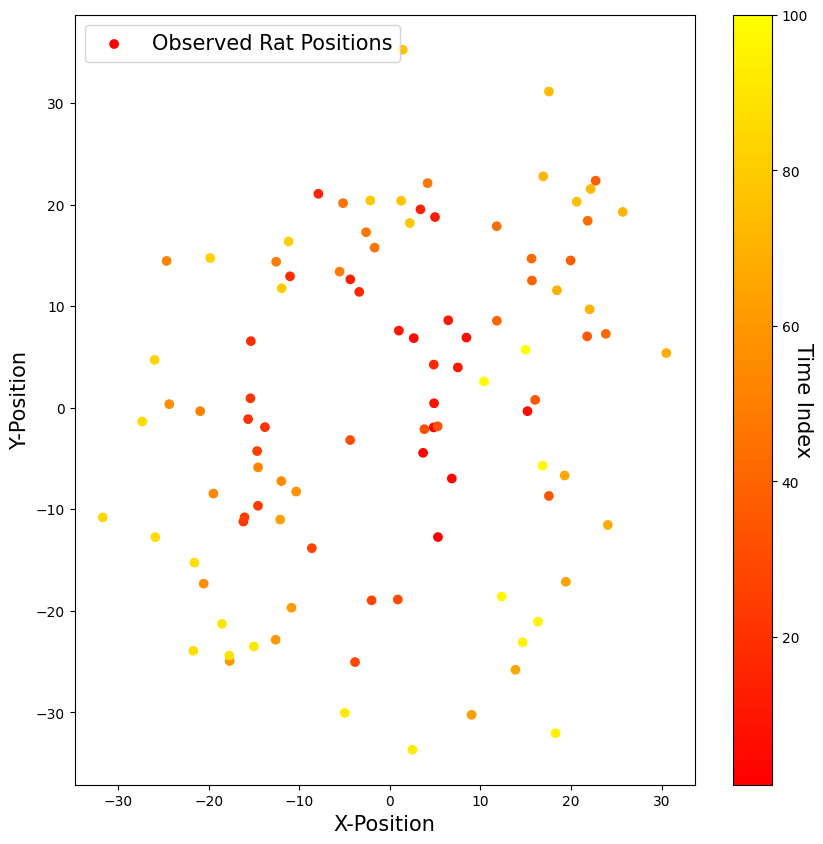

In [19]:
# We start by generating the data our friend collected.
n_timesteps = 100
np.random.seed(1)

transition_matrix = np.array([[1.01, -0.2],[0.2,0.95]])
transition_covariance = 2.0*np.eye(2)

observation_matrix = np.array([[1.0, 0.0],[0.2,1.0]])
observation_covariance = 30.0*np.eye(2)

mu_zero = np.array([1.0,1.2])
cov_zero = 0.1*np.eye(2)

latent_state, observed_state = sample_lds(n_timesteps, transition_matrix, transition_covariance, observation_matrix, observation_covariance, mu_zero, cov_zero)
t_observed = np.arange(len(latent_state))

# Let's plot what our friend collected.
fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=100)
fontsize = 15
plt.scatter(observed_state[:,0],observed_state[:,1], c=t_observed[1:], cmap='autumn', label='Observed Rat Positions')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Time Index', fontsize=fontsize, rotation=270)
plt.xlabel('X-Position', fontsize=fontsize)
plt.ylabel('Y-Position', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

You see where your friend is coming from, but it's really hard to discern an obvious pattern. You decide to model the problem as an LDS where the rat's dance is the latent state. 

* Apply the Kalman filter with the initial guess for the parameters.
* Apply the Kalman filter to the data with 20 steps of expectation-maximization.

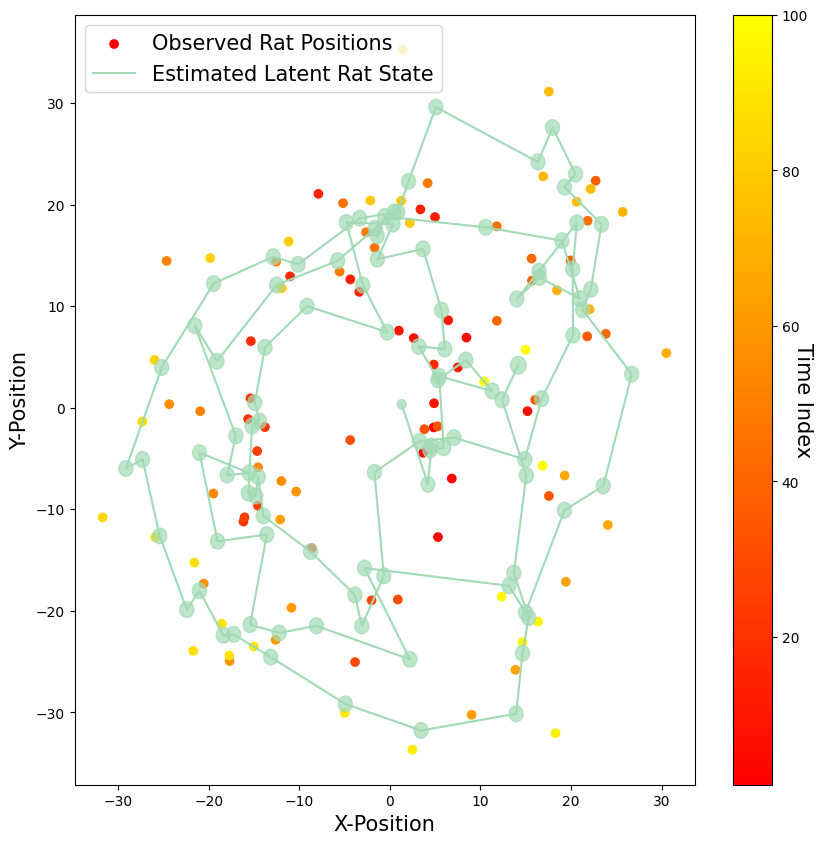

In [22]:
# We'll give you a smart initialization to your EM algorithm for free.
kf = KalmanFilter(sigma_w=3.0, sigma_v=2.0, a=1.0, c=1.0, dim_z=2, dim_x=2, sigma_w_zero=1.0, mu_zero=np.array([1.0, 1.2]))

# TODO: Get smooth latent states with the initial parameter choices. 
smooth_latent_means, smooth_latent_covariances = kf.smooth(observed_state)[:2]

fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=100)
fontsize = 15
plt.scatter(observed_state[:,0],observed_state[:,1], c=t_observed[1:], cmap='autumn', label='Observed Rat Positions')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Time Index', fontsize=fontsize, rotation=270)
plt.xlabel('X-Position', fontsize=fontsize)
plt.ylabel('Y-Position', fontsize=fontsize)
plot_means_and_cov(smooth_latent_means, smooth_latent_covariances, ax=ax, color='#a1dab4', label='Estimated Latent Rat State')
plt.legend(fontsize=fontsize)
plt.show()

Well that doesn't inspire confidence. Let's try again, this time with 20 iteratiosn of EM.

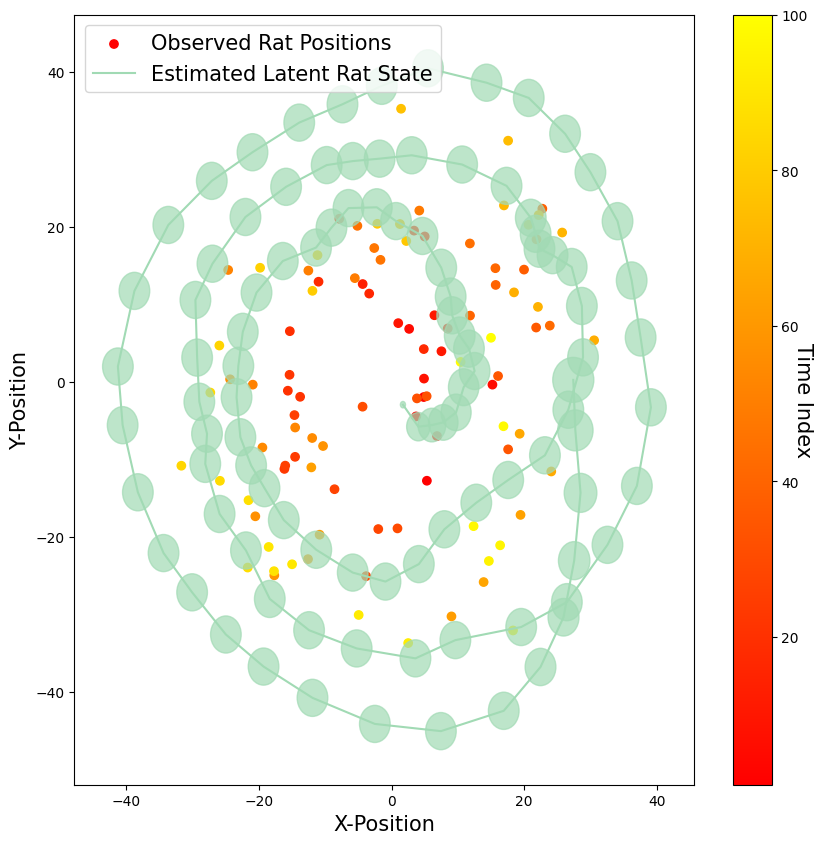

In [23]:
# We'll give you a smart initialization to your EM algorithm for free.
kf = KalmanFilter(sigma_w=3.0, sigma_v=2.0, a=1.0, c=1.0, dim_z=2, dim_x=2, sigma_w_zero=1.0, mu_zero=np.array([1.0, 1.2]))

# TODO: Run 20 iterations of expectation-maximization and extract the smooth latent states with the optimal parameters. 
kf.expectation_maximization(observed_state, 20)
smooth_latent_means, smooth_latent_covariances = kf.smooth(observed_state)[:2]

fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=100)
fontsize = 15
plt.scatter(observed_state[:,0],observed_state[:,1], c=t_observed[1:], cmap='autumn', label='Observed Rat Positions')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Time Index', fontsize=fontsize, rotation=270)
plt.xlabel('X-Position', fontsize=fontsize)
plt.ylabel('Y-Position', fontsize=fontsize)
plot_means_and_cov(smooth_latent_means, smooth_latent_covariances, ax=ax, color='#a1dab4', label='Estimated Latent Rat State')
plt.legend(fontsize=fontsize)
plt.show()

There it is! A beautiful dance. This rat was really feeling inspired by the song. For fun let's cheat and see how well we did of reconstructing the true latent states.

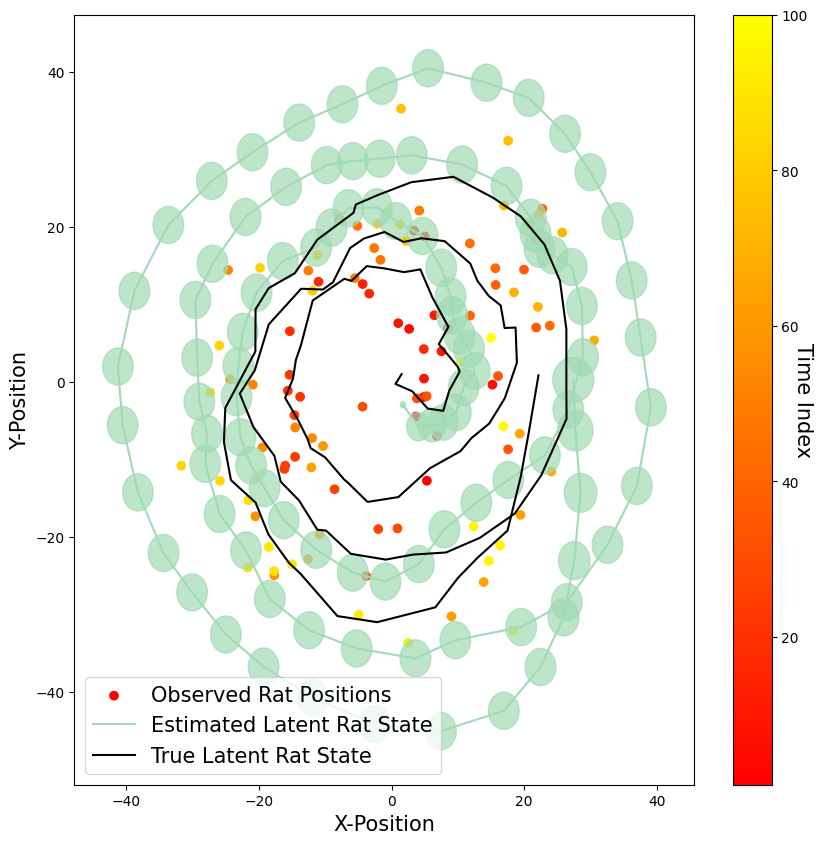

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=100)
fontsize = 15
plt.scatter(observed_state[:,0],observed_state[:,1], c=t_observed[1:], cmap='autumn', label='Observed Rat Positions')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Time Index', fontsize=fontsize, rotation=270)
plt.xlabel('X-Position', fontsize=fontsize)
plt.ylabel('Y-Position', fontsize=fontsize)
plot_means_and_cov(smooth_latent_means, smooth_latent_covariances, ax=ax, color='#a1dab4', label='Estimated Latent Rat State')
plt.plot(latent_state[:,0], latent_state[:,1], '-', c='k', label='True Latent Rat State')
plt.legend(fontsize=fontsize)
plt.show()

If everything went well, you should have done a good job of reconstructing the true latent states.